Link to my GitHub repo: https://github.com/BU-IE-582/fall19-erdembanak

In [5]:
library(data.table)
library(ggplot2)
library(ggthemes)
library(stringr)

In [6]:
bets <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/bets.csv")
booking <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/booking.csv")
goals <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/goals.csv")
matches <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/matches.csv")
stats <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/stats.csv")

matches <- matches[league_id == 148,]


# Task 1

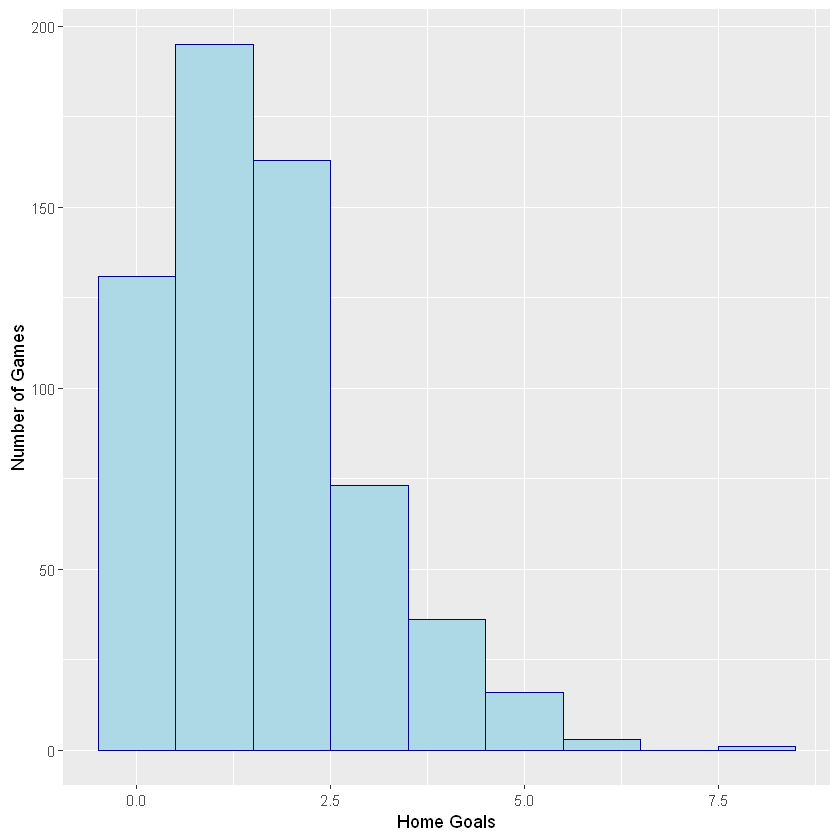

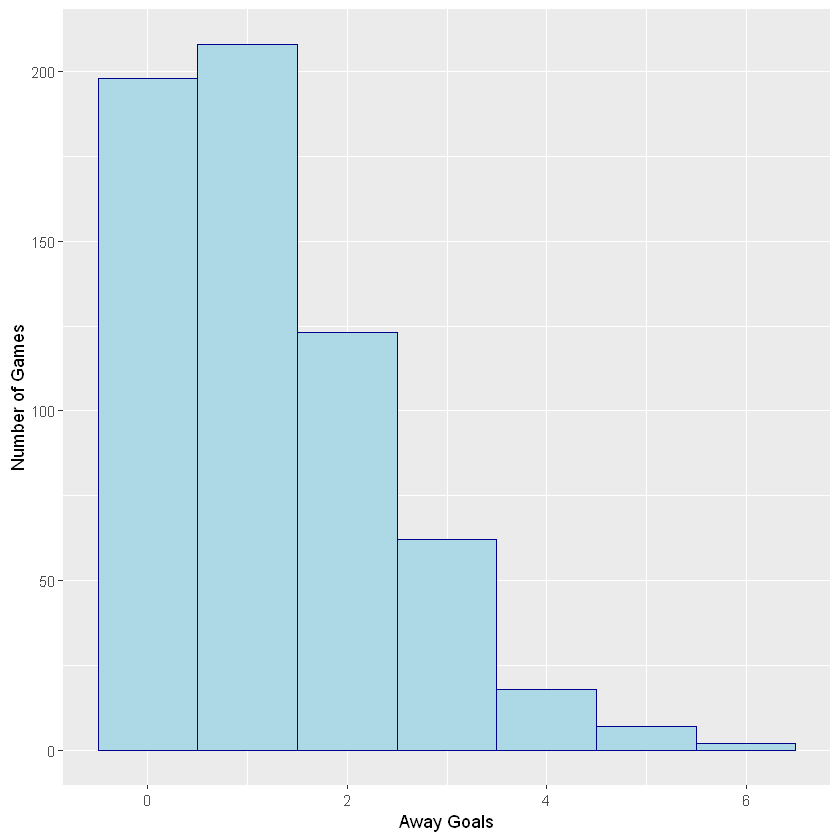

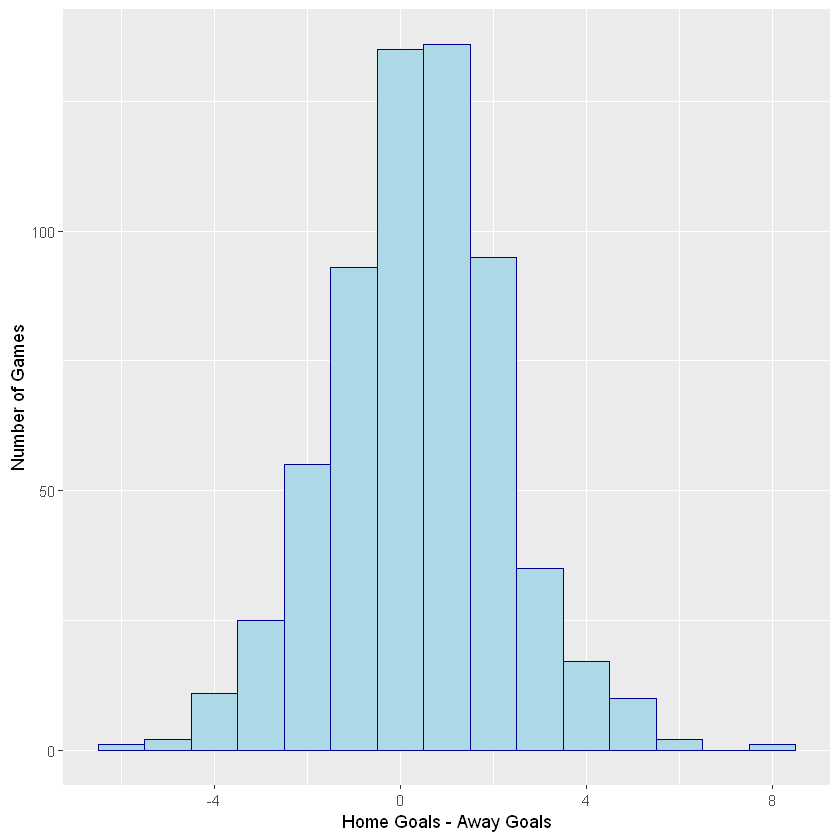

In [7]:

goals_by_team <- matches[match_status == 'Finished', .(HomeGoals = match_hometeam_score,
                                                       AwayGoals = match_awayteam_score)]

ggplot(goals_by_team, aes(x = HomeGoals)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Home Goals", y = "Number of Games")
  
ggplot(goals_by_team, aes(x = AwayGoals)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Away Goals", y = "Number of Games")

ggplot(goals_by_team, aes(x=HomeGoals - AwayGoals)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Home Goals - Away Goals", y = "Number of Games")


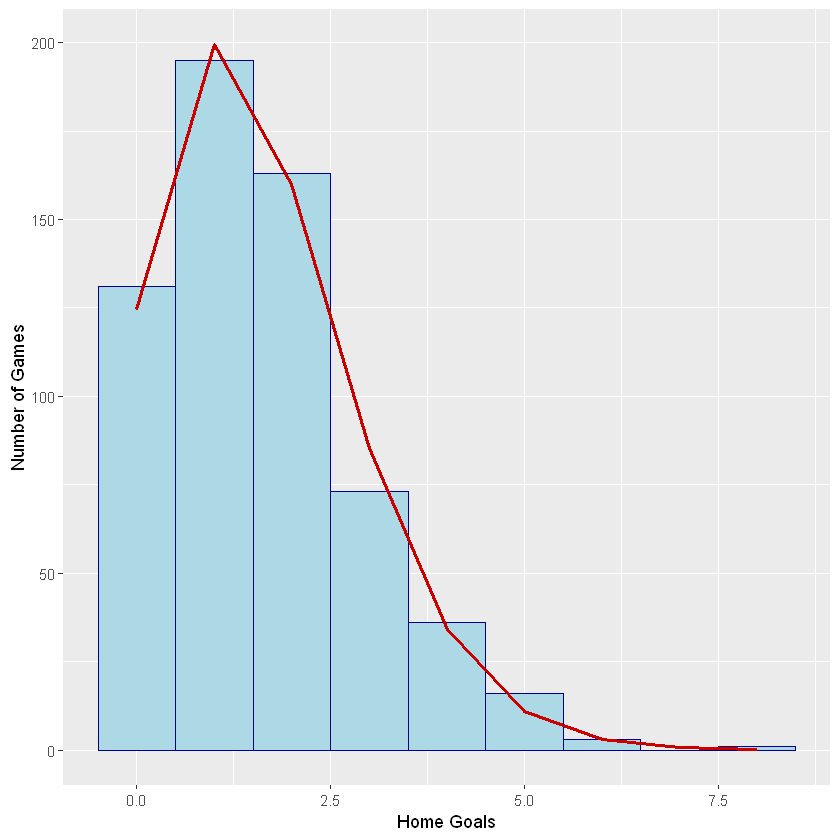

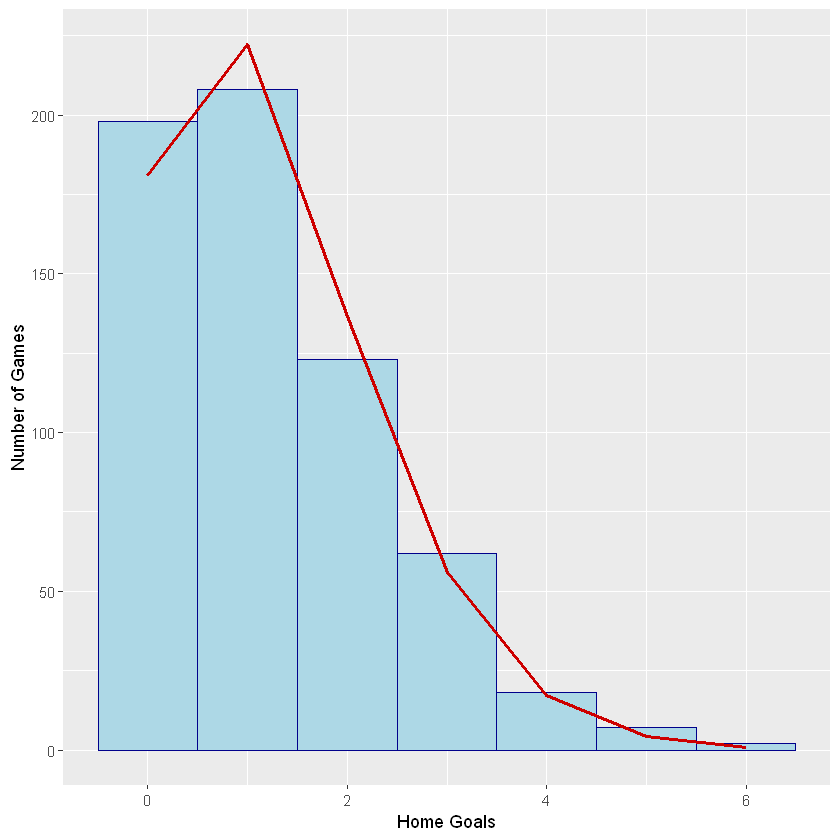

In [9]:
# Tasks 1b

homegoals_mean <- goals_by_team[, mean(HomeGoals)]
awaygoals_mean <- goals_by_team[, mean(AwayGoals)]
scale <- nrow(goals_by_team)

values <- max(goals_by_team[, HomeGoals]) + 1
ggplot(goals_by_team, aes(x = HomeGoals)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Home Goals", y = "Number of Games") +
  stat_function(fun = function(x) dpois(x, lambda = homegoals_mean) * 1 * scale,
                color = "red3", size = 1, n = values)

values <- max(goals_by_team[, AwayGoals]) + 1
ggplot(goals_by_team, aes(x = AwayGoals)) + 
  geom_histogram(color="darkblue", fill="lightblue", binwidth = 1) +
  labs(x="Home Goals", y = "Number of Games") +
  stat_function(fun = function(x) dpois(x, lambda = awaygoals_mean) * 1 * scale,
                color = "red3", size = 1, n = values)


Looks like Poisson distribution is a good fit for both of the graphs.

# Task 2

I need a unique match id - bookmarker combinations; I will be using epoch's for doing this. I am only interested in odd_1, odd_x and odd_2. I want an epoch to have all 3 of them since I will normalize the odds later.

I want to have a data table having Bookmarker - MatchId - DrawProbability - HomeWinProbability - AwayWinProbability as columns.

In [10]:
# Task 2.1

get <- bets[variable %in% c("odd_1",
                            "odd_x",
                            "odd_2"), .(BookMarker = odd_bookmakers,
                                        MatchId = match_id,
                                        OddEpoch = odd_epoch,
                                        Variable = variable,
                                        Odd = value, 
                                        Prob = 1/value)]

# An odd can't be below 1.

get <- get[Odd > 1]
get <- na.omit(get)

get[, Variable := ifelse(Variable == 'odd_1', 'HomeWin', 
                         ifelse(Variable == 'odd_2', 'AwayWin', 
                                'Draw'))]

get[, MaxEpoch := max(OddEpoch), .(MatchId, BookMarker)]
get <- get[OddEpoch == MaxEpoch,]

# Casted to have a bookmarker - matchid combination in just one line

casted <- dcast(get, BookMarker + MatchId ~ Variable, value.var = c("Odd", "Prob"))
casted <- na.omit(casted)

# Task 2.2
casted[, ProbNormalizeRatio := 1/(1/Odd_HomeWin + 1/Odd_AwayWin + 1/Odd_Draw)]

casted[, Prob_AwayWin_Normalized := Prob_AwayWin*ProbNormalizeRatio]
casted[, Prob_HomeWin_Normalized := Prob_HomeWin*ProbNormalizeRatio]
casted[, Prob_Draw_Normalized := Prob_Draw*ProbNormalizeRatio]

casted <- na.omit(casted)


I need to work on matches finished and I will map the results.


In [11]:
matches_finished <- matches[match_status == 'Finished',]
matches_finished[match_hometeam_score > match_awayteam_score, Result := 'HomeWin']
matches_finished[match_hometeam_score < match_awayteam_score, Result := 'AwayWin']
matches_finished[match_hometeam_score == match_awayteam_score, Result := 'Draw']

matches_finished <- matches_finished[, .(MatchId = match_id, Result)]

setkey(casted, MatchId)
setkey(matches_finished, MatchId)

casted <- matches_finished[casted, nomatch = 0]

We will work with the same plot from now on; therefore I will use a function to call it easily. We can create bins based on match counts (100 matches in each bin) or range (-1 to -0.8, -0.8 to -0.6 type of definitions) using the function. I will use the default option and work with 10 bins using range.

In [12]:
draw_prob_plot <- function(data, bin_count = 10, equal_on = "range"){
  # Range vs count. If range is selected, equal distances on the line: 
  # (-1,-0.8], (-0.8, 0.6]. If count is selected, equal number of elements
  # in a group
  
  data[, Difference := Prob_HomeWin - Prob_AwayWin]
  if (equal_on == "count"){
    data <- data[order(Difference)]
    no_elements <- floor(nrow(data)/bin_count)
    data[, Order := 1:.N]
    data[, Group := ceiling(Order/no_elements)]
    data[Group == (bin_count + 1), Group := Group - 1]
    data[, MidPointBin := mean(Difference), Group]
  }
  
  if (equal_on == "range"){
    for (i in 0:(bin_count-1)){
      data[Prob_HomeWin - Prob_AwayWin > -1 + i*2/bin_count
           & Prob_HomeWin - Prob_AwayWin <= -1 + (i+1)*2/bin_count,
           MidPointBin := -1 + 2*i/bin_count + 1/bin_count]
    }
  }
  
  draw_info <- data[, .(BetDrawProbability = mean(Prob_Draw),
                        BetDrawProbabilityNormalized = mean(Prob_Draw*ProbNormalizeRatio),
                        EstimatedDrawProbability = sum(Result == 'Draw')/.N), .(MidPointBin)] 
  
  bookmarkers <- data[, unique(BookMarker)]
  if (length(bookmarkers) > 1){
    title <- "All"
  }else{
    title <- bookmarkers
  }
  
  draw_info <- draw_info[, .(MidPointBin,
                             BetDrawProbability,
                             EstimatedDrawProbability,
                             RibbonMin = ifelse(BetDrawProbability > EstimatedDrawProbability,
                                                EstimatedDrawProbability,
                                                BetDrawProbability),
                             RibbonMax = ifelse(BetDrawProbability < EstimatedDrawProbability,
                                                EstimatedDrawProbability,
                                                BetDrawProbability))]
  
  ggplot(draw_info, aes(x=MidPointBin, y = BetDrawProbability)) + 
    geom_point(size = 2) + geom_line(aes(color = "BetsProb")) +
    geom_point(aes(y = EstimatedDrawProbability), size = 2, color = "red2") +
    geom_line(aes(x=MidPointBin, y=EstimatedDrawProbability, color = "EstimatedProb")) +
    geom_ribbon(aes(ymin = RibbonMin, ymax = RibbonMax), fill = 'blue',alpha = 0.1) +
    labs(title = title) +
    xlab("P(home win) - P(away win)") +
    ylab("P(Draw)") +
    theme(panel.background = element_rect(fill = "#BFD5E3", colour = "#6D9EC1",
                                      size = 2, linetype = "solid"),
          panel.grid.major = element_blank(),
          axis.text = element_text(size = 11),
          axis.title = element_text(size = 13, face = "bold"),
          plot.title = element_text(hjust = 0.5, size = 15, face = "bold"),
          legend.position = c(0.75,0.12), 
          legend.direction = "horizontal",
          legend.justification = c("right", "top"),
          legend.title.align=0.5) +
    scale_color_manual(values = c("black", "red2"),
                       labels = c("BetProbability", "EstimatedProbability"))
}

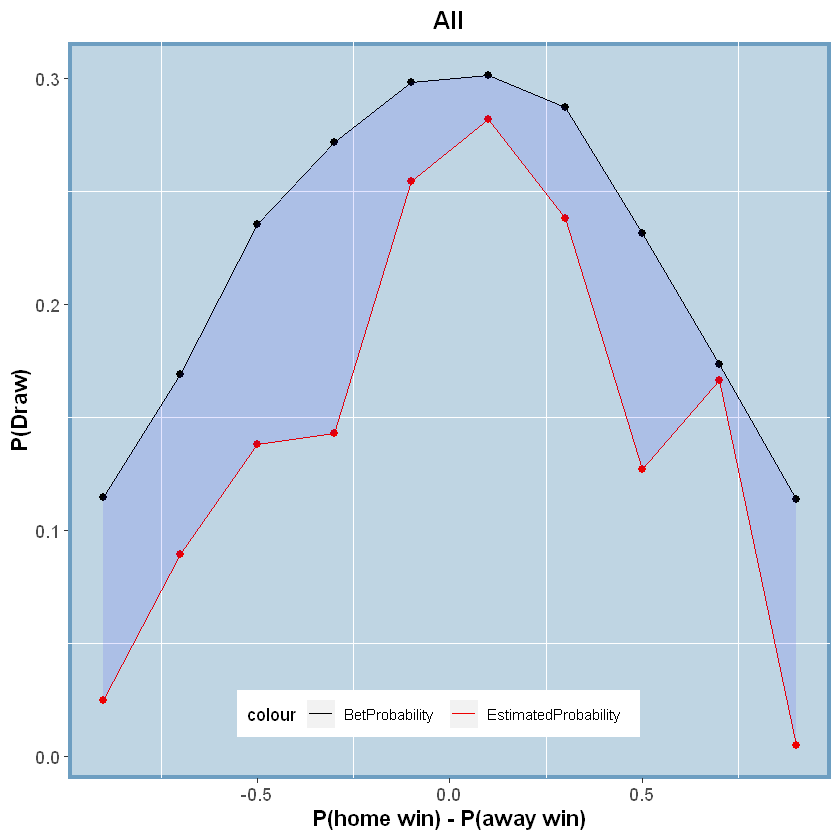

In [13]:
draw_prob_plot(casted, 10, equal_on = "range")

There isn't any winning opportunity in long term when looking the graph for all bookmarkers. Estimated probability is always below bookmarkers' probability.

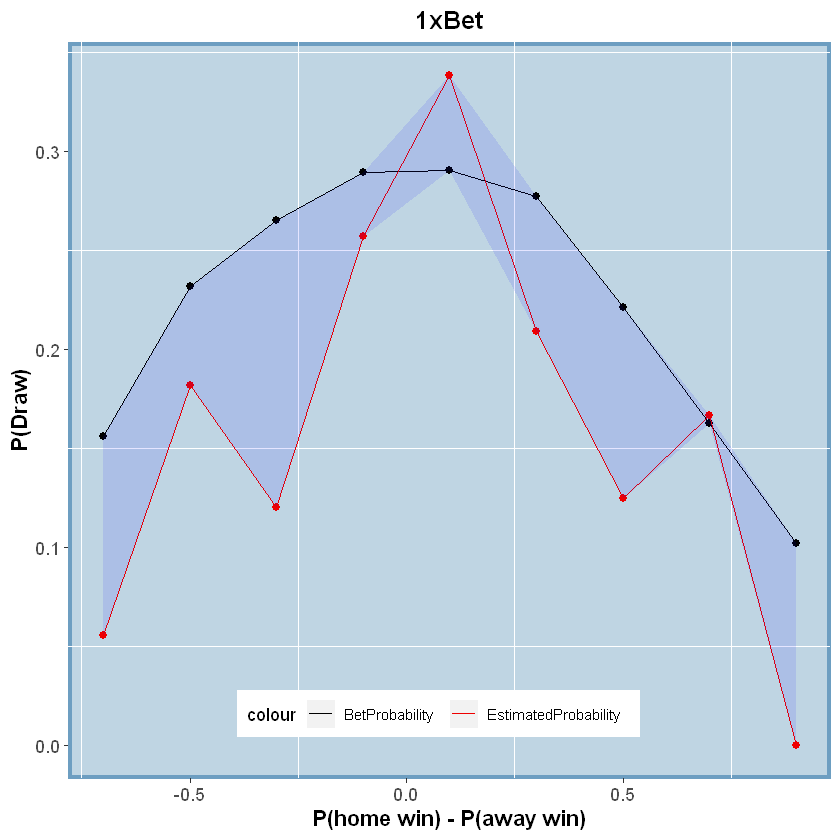

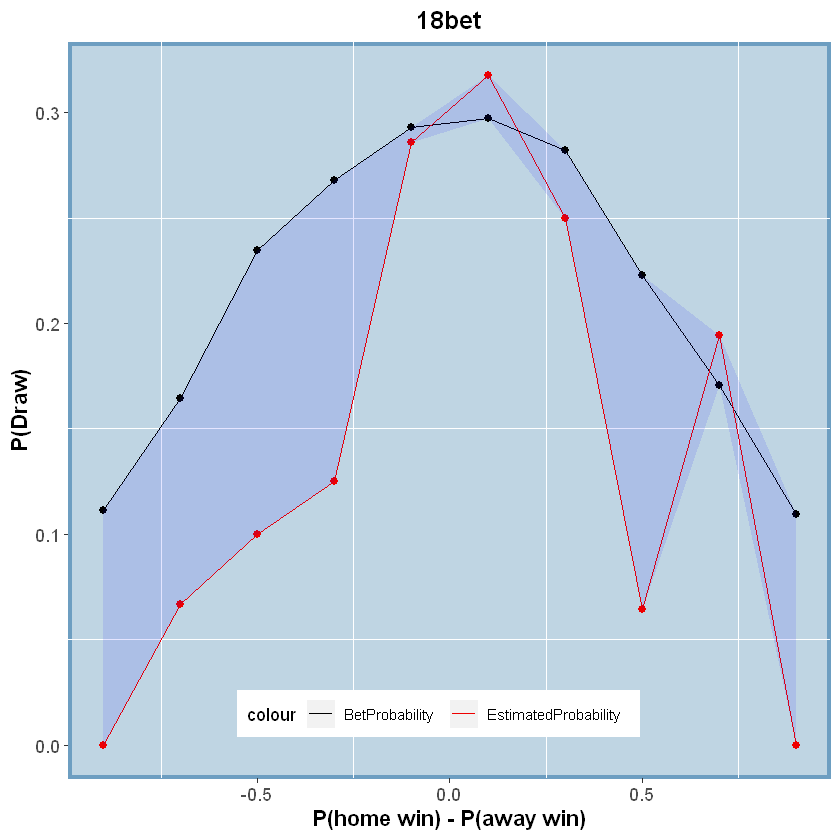

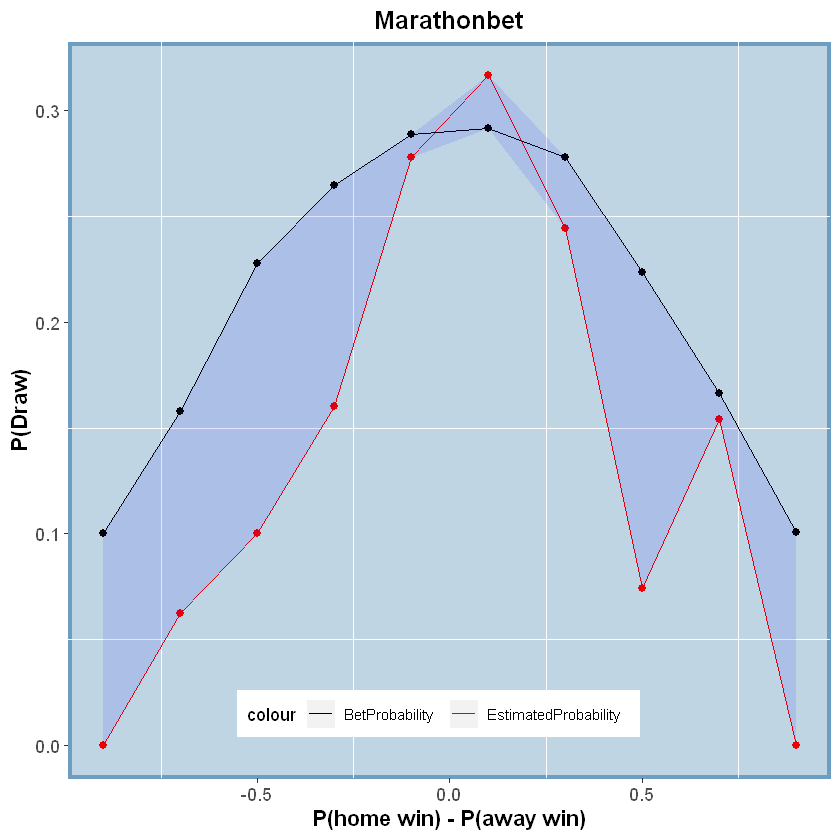

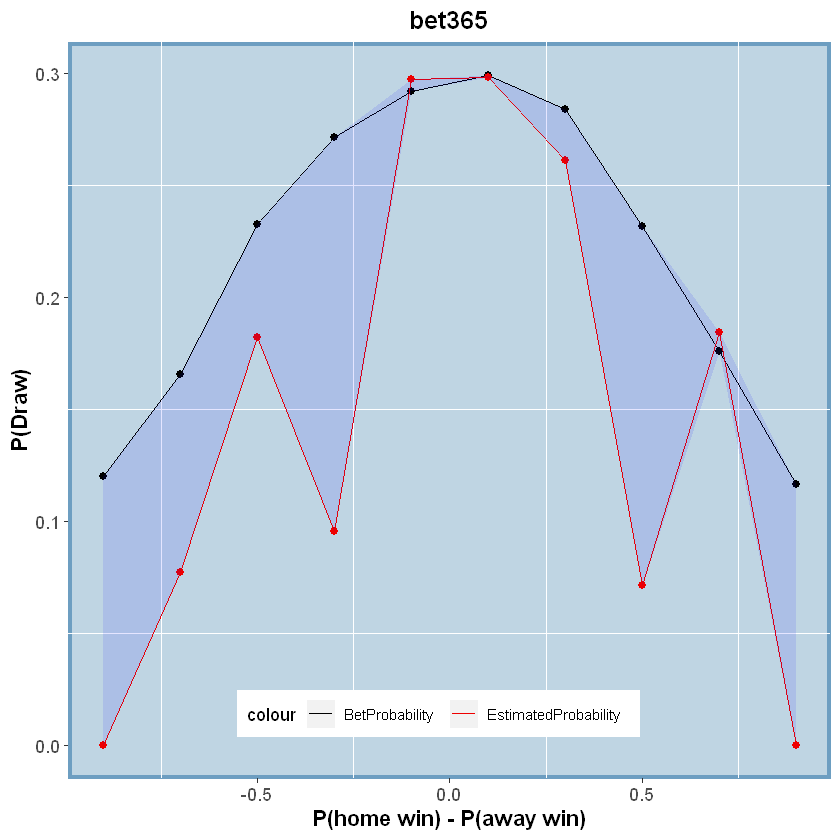

In [14]:
bettors <- bets[, .N, odd_bookmakers][order(-N)][1:4, odd_bookmakers]

for (i in bettors){
    bettor_data <- casted[BookMarker == i]
    print(draw_prob_plot(bettor_data, 10, equal_on = "range"))
}


There are some possibilities to win around 0 - 0.2. It looks like bookmarkers are underestimating the draw probability when the match looks more in-between.

Also 0, 0.2 bin also presents some opportunity to win especially in 1XBet.


# Task 3

I will be removing matches with red card in first 15 minutes and matches with result changes (a win becoming a draw or vice versa) in 90+.

I need to convert 90+ into integer to be able to work easily with minutes.

In [15]:
booking[, Time := as.integer(str_split_fixed(time, "\\+",2)[, 1])]
booking[, AdditionalTime := as.integer(str_split_fixed(time, "\\+",2)[, 2])]
booking[is.na(AdditionalTime), AdditionalTime := 0]

In [16]:
goals[, Time := as.integer(str_split_fixed(time, "\\+",2)[, 1])]
goals[, AdditionalTime := as.integer(str_split_fixed(time, "\\+",2)[, 2])]
goals[is.na(AdditionalTime), AdditionalTime := 0]

In [17]:
goals[, HomeScore := as.integer(str_split_fixed(score, "\\-",2)[, 1])]
goals[, AwayScore := as.integer(str_split_fixed(score, "\\-",2)[, 2])]
goals[, ScoredSide := ifelse(nchar(home_scorer) > 0, 'Home', 'Away')]

draw <- goals[Time >= 90 & HomeScore == AwayScore, match_id]
h_win <- goals[Time >= 90 & HomeScore + AwayScore == 1 & ScoredSide == 'Home', match_id]
a_win <- goals[Time >= 90 & HomeScore - AwayScore == -1 & ScoredSide == 'Away', match_id]


In [18]:
matches_with_red_card <- booking[time <= 15 & card == 'red card', match_id]
matches_with_last_min_goals <- c(draw, h_win, a_win)

print(paste0("Number of matches with red card in first 15 minutes: ", length(matches_with_red_card)))
print(paste0("Number of matches with last minute goals changing the result: ", length(matches_with_last_min_goals)))


[1] "Number of matches with red card in first 15 minutes: 17"
[1] "Number of matches with last minute goals changing the result: 223"


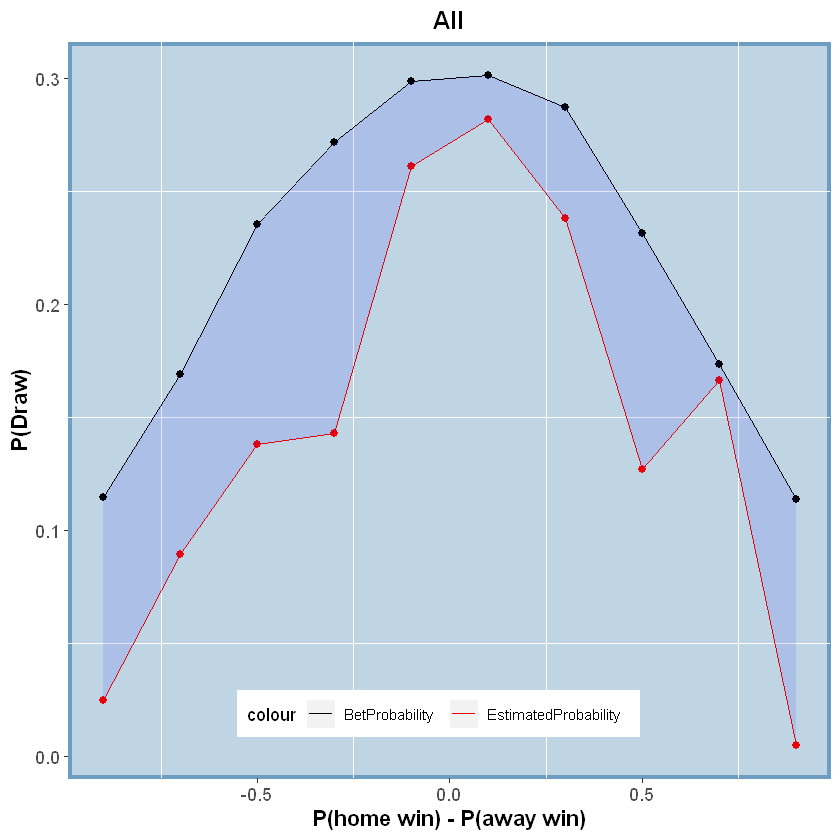

In [19]:
w_o_red <- casted[!MatchId %in% matches_with_red_card]
draw_prob_plot(w_o_red, 10, equal_on = "range")

There arent't many matches with red cards in the first 15 minutes apparently. Therefore the result didn't change much.

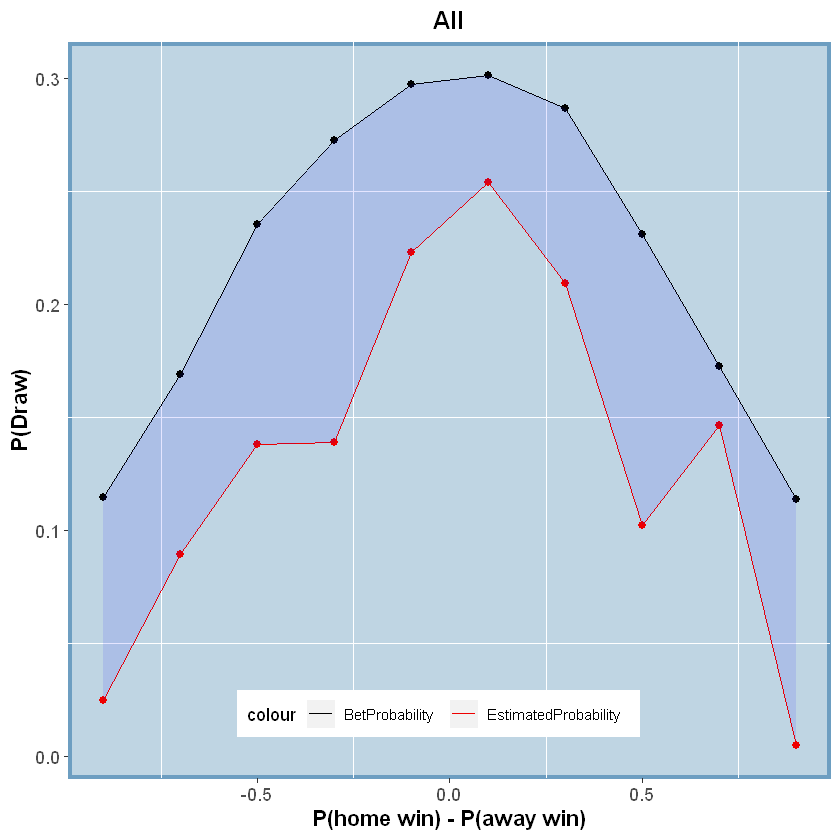

In [20]:
w_o_lmgoal <- casted[!MatchId %in% matches_with_last_min_goals]
draw_prob_plot(w_o_lmgoal, 10, equal_on = "range")


Bettor odds looked better when we are eliminating the last minute result changes. There is a higher gap between bookmarker probabilities and estimated probabilities.